In [1]:
# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# Standardize the data (padronização)
from sklearn.preprocessing import StandardScaler

# Modeling 
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [2]:
# vamos importar a base de produção de energia elétrica
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv', index_col='inicio_semana', parse_dates=True)
# df = pd.read_csv('C:\projetos\jupyter_notebook\hyperparams_optimization\_data\pld_norte.csv', index_col='inicio_semana', parse_dates=True)

# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


In [3]:
df = df.drop(columns=['preco_pesado','preco_leve','geracao_hidraulica','geracao_termica','carga_energia','reservatorio_EARM','reservatorio_ENA'])
# df = df[23:len(df)-22]
df

,preco_medio
inicio_semana,
2001-08-04,684.00
2001-08-11,684.00
2001-08-18,684.00
2001-08-25,684.00
2001-09-01,684.00
...,...
2009-11-28,16.31
2009-12-05,16.31
2009-12-12,16.31


Text(0, 0.5, 'Preço médio (R$)')

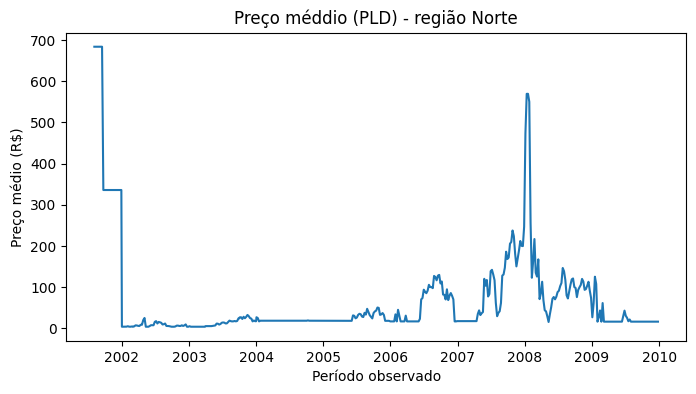

In [4]:
plt.subplots(figsize=(8,4))
plt.plot(df)
plt.title('Preço méddio (PLD) - região Norte')
plt.xlabel('Período observado')
plt.ylabel('Preço médio (R$)')

## Pré-processamento
> Separação dos dados em treino / teste

In [5]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [6]:
train, test = split_dataset(df, 0.75, True)


BASE DE TREINO
                preco_medio
inicio_semana             
2007-10-06          172.08
2007-10-13          205.54
2007-10-20          209.96
2007-10-27          237.66
2007-11-03          223.89

BASE DE TESTE
                preco_medio
inicio_semana             
2007-11-10          181.30
2007-11-17          150.54
2007-11-24          169.65
2007-12-01          189.25
2007-12-08          212.20


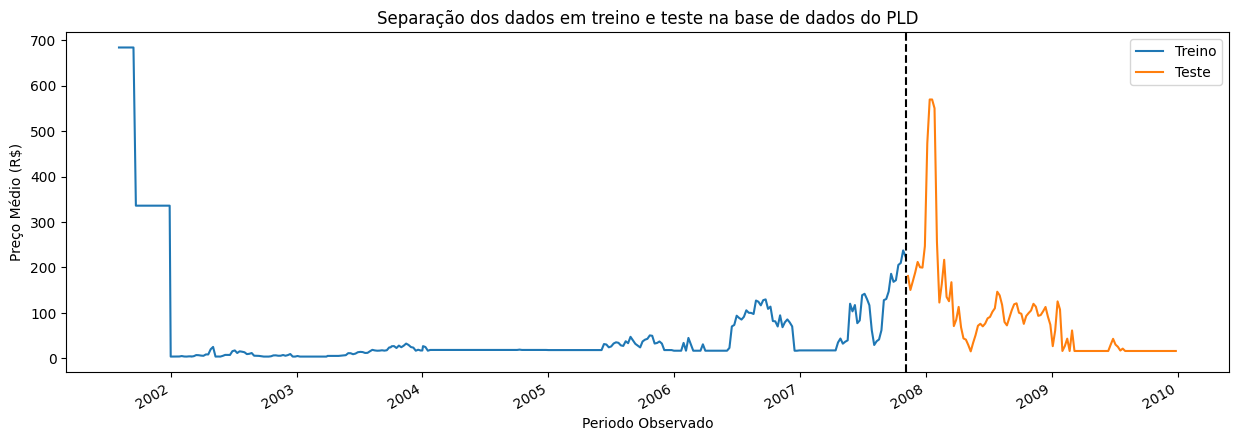

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Treino', title='Separação dos dados em treino e teste na base de dados do PLD')
test.plot(ax=ax, label='Teste')
ax.axvline('2007-11-03', color='black', ls='--')
ax.legend(['Treino', 'Teste'])
plt.xlabel("Periodo Observado")
plt.ylabel("Preço Médio (R$)")
plt.show()

> Feature Engineering

In [8]:
def series_to_supervised_lag(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:] # remove linhas iniciais com nan
    return features

### Plotagem  das Previsões Diretas

In [9]:
def predict_svr(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale', lag=1):

    # Criação dos Lags
    steps_in = lag
    train_data_features = series_to_supervised_lag(train, steps_in)
    test_data_features = series_to_supervised_lag(test, steps_in)

    # Definição de X e y
    X_train = train_data_features.drop(columns=['t']).values
    y_train = train_data_features['t'].values.reshape(-1, 1)
    X_test = test_data_features.drop(columns=['t']).values
    y_test = test_data_features['t'].values.reshape(-1, 1)

    # Inicializa a padronização
    sc = StandardScaler()
    X_train_transformed = pd.DataFrame(sc.fit_transform(X_train))
    X_test_transformed = pd.DataFrame(sc.transform(X_test))

    # treina o modelo
    svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train_transformed, y_train)
    predictions = svr.predict(X_test_transformed)

    # adicionando as datas
    previsao = pd.DataFrame(test_data_features['t'])
    previsao = previsao.drop(columns=['t'])
    previsao['validacao'] = y_test
    previsao['previsao'] = predictions
    previsao
        
    # calculo do erro
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)

    fig = plt.subplots(figsize=(10,4))
    # plt.plot(y_test[:100], label='Validação')
    plt.plot(previsao['validacao'], label='Validação')
    plt.plot(previsao['previsao'], '--', label='Previsão')
    plt.title('Previsão direta para o PLD da região Norte - MSE: {:.3f} || RMSE: {:.3f}'.format(mse, rmse))
    plt.xlabel('Periodo Observado')
    plt.ylabel('Preço Médio (R$)')
    plt.legend()
    plt.tight_layout()

    return previsao, rmse, mse

BASE DE TREINO:  332
BASE DE TESTE:   111


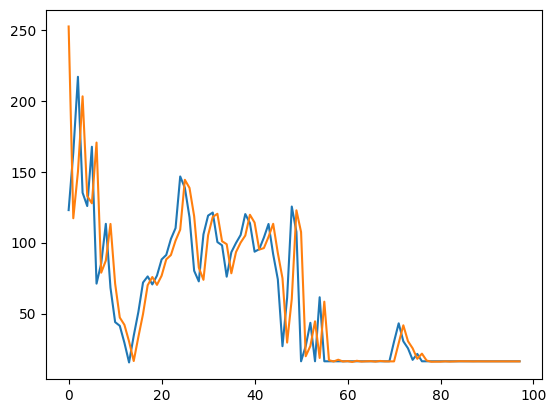

In [10]:
train, test = split_dataset(df, 0.75, False)
steps_in = 13
train_data_features = series_to_supervised_lag(train, steps_in)
test_data_features = series_to_supervised_lag(test, steps_in)

# Definição de X e y
X_train = train_data_features.drop(columns=['t']).values
y_train = train_data_features['t'].values.reshape(-1, 1)
X_test = test_data_features.drop(columns=['t']).values
y_test = test_data_features['t'].values.reshape(-1, 1)

# Inicializa a padronização
sc = StandardScaler()
X_train_transformed = pd.DataFrame(sc.fit_transform(X_train))
X_test_transformed = pd.DataFrame(sc.transform(X_test))

# treina o modelo
# svr = SVR(C=1000.0, gamma=9.70e-07)
svr = SVR(C=10000, gamma=0.0005155974146484479)
# svr = SVR()
svr.fit(X_train_transformed, y_train)
predictions = svr.predict(X_test_transformed)
# https://medium.com/data-hackers/normalizar-ou-padronizar-as-variáveis-3b619876ccc9
# pred_test = sc.inverse_transform(predictions.reshape(-1, 1))
# sc.inverse_transform(predictions)

plt.plot(y_test)
plt.plot(predictions)

> Bayes Search

In [11]:
print(round(9.688731159500935e-07, 8))

9.7e-07


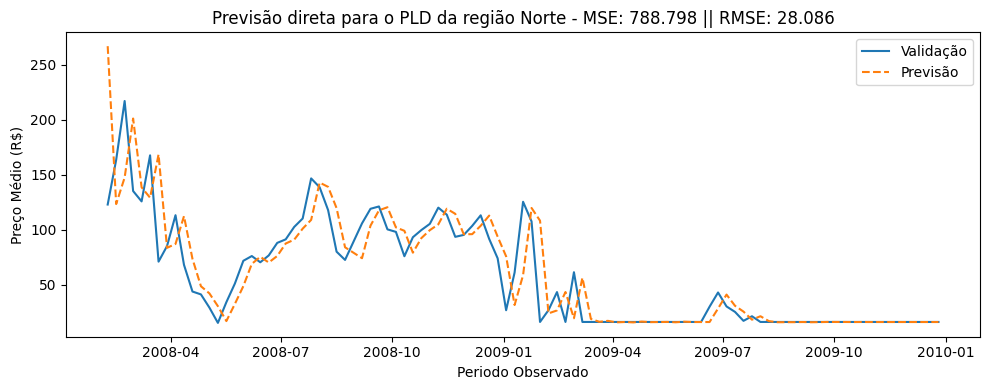

In [12]:
# previsao_bs, rmse_bs, mse_bs = predict_svr(C=1000.0, gamma=9.70e-07, lag=13)
previsao_bs, rmse_bs, mse_bs = predict_svr(C=7000, epsilon=1e-01, gamma=0.0005155974146484479, lag=13)

> Random Search

In [13]:
print(round(4.641588833612773e-06, 8))

4.64e-06


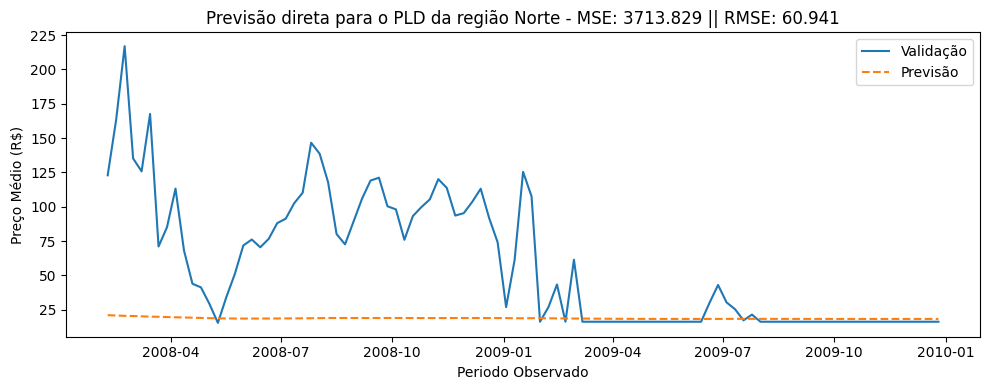

In [14]:
previsao_rs, rmse_rs, mse_rs = predict_svr(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.64e-06, lag=13)

> Ajustando a previsão

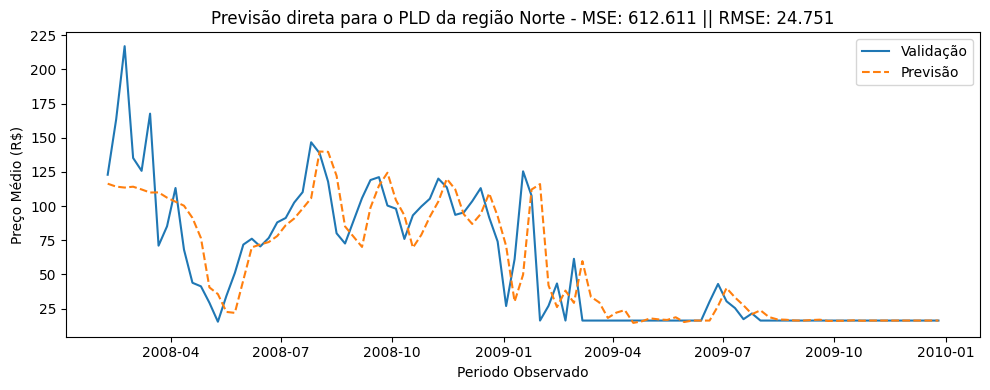

In [15]:
previsao, rmse, mse = predict_svr(C=100, epsilon=5e-06, lag=13)

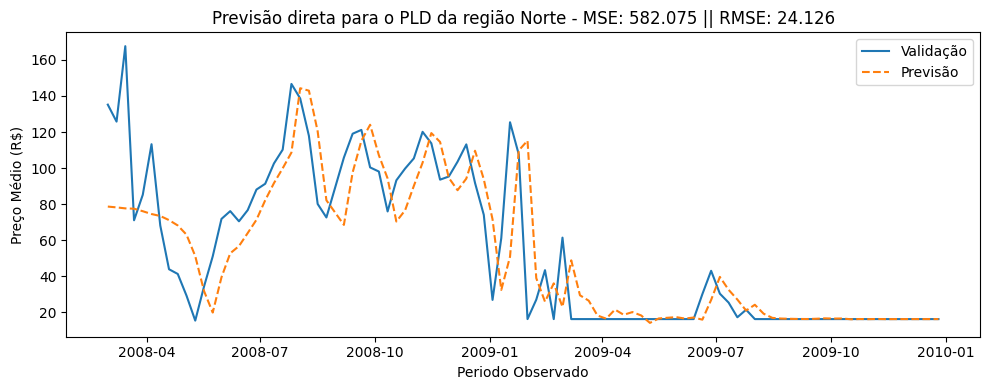

In [16]:
previsao, rmse, mse = predict_svr(C=100, epsilon=5e-06, lag=16)

[DatetimeIndex(['2008-03-01', '2008-03-08', '2008-03-15', '2008-03-22',
               '2008-03-29', '2008-04-05', '2008-04-12', '2008-04-19',
               '2008-04-26', '2008-05-03', '2008-05-10', '2008-05-17',
               '2008-05-24', '2008-05-31', '2008-06-07', '2008-06-14',
               '2008-06-21', '2008-06-28', '2008-07-05', '2008-07-12',
               '2008-07-19', '2008-07-26', '2008-08-02', '2008-08-09',
               '2008-08-16', '2008-08-23', '2008-09-06', '2008-09-13',
               '2008-09-20', '2008-09-27', '2008-10-04', '2008-10-11',
               '2008-10-18', '2008-10-25', '2008-11-01', '2008-11-08',
               '2008-11-15', '2008-11-22', '2008-11-29', '2008-12-06',
               '2008-12-13', '2008-12-20', '2008-12-27', '2009-01-03',
               '2009-01-10', '2009-01-17', '2009-01-24', '2009-01-31',
               '2009-02-07', '2009-02-14', '2009-02-21', '2009-02-28',
               '2009-03-07', '2009-03-14', '2009-03-21', '2009-03-28',
     

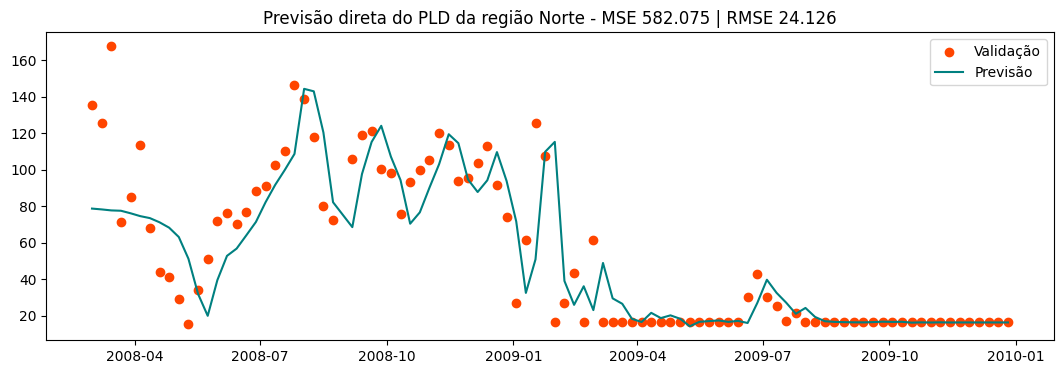

In [17]:
date = []
date.append(pd.DataFrame(previsao).index)
print(date)

fig = plt.subplots(figsize=(13, 4))
plt.scatter(date, previsao['validacao'], label='Validação', color='orangered')
plt.plot(previsao['previsao'], label='Previsão', color='teal')
plt.title(f'Previsão direta do PLD da região Norte - MSE {mse:.3f} | RMSE {rmse:.3f}')
plt.legend()

In [18]:
compare_prev = pd.DataFrame()
compare_prev['bayes-search'] = pd.DataFrame(previsao_bs['previsao'])
compare_prev['random-search'] = pd.DataFrame(previsao_rs['previsao'])
compare_prev

,bayes-search,random-search
inicio_semana,,
2008-02-09,266.732807,21.106299
2008-02-16,123.348792,20.821548
2008-02-23,147.471892,20.606766
2008-03-01,201.021886,20.472034
2008-03-08,138.564765,20.239782
...,...,...
2009-11-28,16.255468,18.342159
2009-12-05,16.255468,18.342159
2009-12-12,16.255468,18.342159


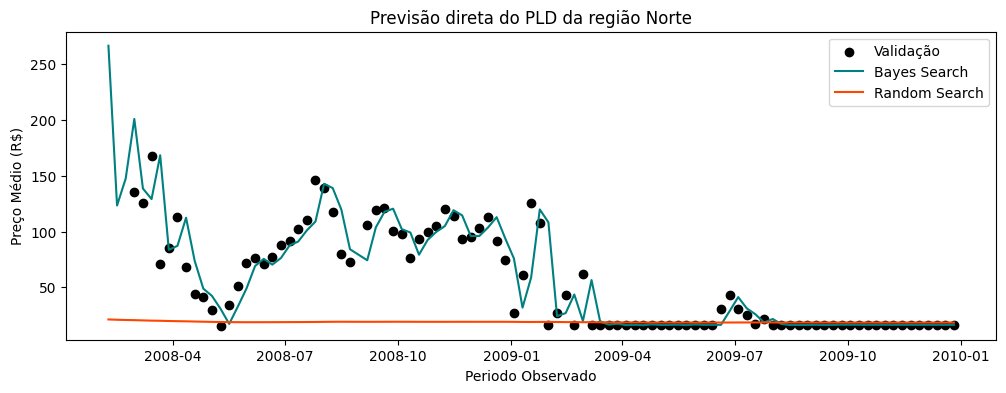

In [19]:
fig = plt.subplots(figsize=(12, 4))
plt.scatter(date, previsao['validacao'], label='Validação', color='black')
plt.plot(compare_prev['bayes-search'], label='Bayes Search', color='teal')
plt.plot(compare_prev['random-search'], label='Random Search', color='orangered')
# plt.title(f'Previsão direta do PLD da região Norte\nBayes Search: MSE {mse_bs:.3f} e RMSE {rmse_bs:.3f} || Random Search: MSE {mse_rs:.3f} e RMSE {rmse_rs:.3f}')
plt.legend()
plt.title('Previsão direta do PLD da região Norte')
# plt.legend(['Validação',
#             ['Bayes Search: ',f'mse: {mse_bs:.3f} rmse: {rmse_bs:.3f}'],
#             ['Random Search: ',f'mse: {mse_rs:.3f} rmse: {rmse_rs:.3f}']
#            ])
plt.xlabel('Periodo Observado')
plt.ylabel('Preço Médio (R$)')
plt.show()

### Plotagem das previsões iterativas

In [20]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

def series_to_supervised(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['target+'+str(i)] = serie.shift(-i)
    features = features.dropna() # remove linhas iniciais com nan
    return features

In [21]:
train_set, test_set = split_dataset(df, 0.75, True)


BASE DE TREINO
                preco_medio
inicio_semana             
2007-10-06          172.08
2007-10-13          205.54
2007-10-20          209.96
2007-10-27          237.66
2007-11-03          223.89

BASE DE TESTE
                preco_medio
inicio_semana             
2007-11-10          181.30
2007-11-17          150.54
2007-11-24          169.65
2007-12-01          189.25
2007-12-08          212.20


In [22]:
train_data_features = series_to_supervised(serie=train_set, steps_in=5)
test_data_features = series_to_supervised(serie=test_set, steps_in=6)
train_data_features[len(train_data_features)-10:]

,t,target+1,target+2,target+3,target+4,target+5
inicio_semana,,,,,,
2007-07-28,61.66,29.52,37.68,41.67,61.98,128.10
2007-08-04,29.52,37.68,41.67,61.98,128.10,130.81
2007-08-11,37.68,41.67,61.98,128.10,130.81,147.26
2007-08-18,41.67,61.98,128.10,130.81,147.26,186.16
2007-08-25,61.98,128.10,130.81,147.26,186.16,168.46
2007-09-01,128.10,130.81,147.26,186.16,168.46,172.08
2007-09-08,130.81,147.26,186.16,168.46,172.08,205.54
2007-09-15,147.26,186.16,168.46,172.08,205.54,209.96
2007-09-22,186.16,168.46,172.08,205.54,209.96,237.66


In [23]:
def fit_predict_steps(passos=1, C=1.0, epsilon=0.1, gamma=1.0):
    train_set, test_set = split_dataset(df, 0.75, False)

    # Inicializa a padronização
    sc = StandardScaler()

    predicted = []
    yTrue = []
    mae_error = []
    mse_error = []
    rmse_error = []

    for i in range(1, passos+1):
        train_data_features = series_to_supervised(serie=train_set, steps_in=i)
        test_data_features = series_to_supervised(serie=test_set, steps_in=i)

        X_train = train_data_features.drop(columns=['target+'+str(i)]).values
        y_train = train_data_features.iloc[:,[i]].values
        X_test = test_data_features.drop(columns=['target+'+str(i)]).values
        y_test = test_data_features.iloc[:,[i]].values

        # padronização
        # X_train_transformed = pd.DataFrame(sc.fit_transform(X_train))
        # X_test_transformed = pd.DataFrame(sc.transform(X_test))

        # treina o modelo
        svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
        svr.fit(X_train, y_train)

        pred = svr.predict([X_test[0]])
        true = y_test[0]
        mae = mean_absolute_error(pred, true)
        mse = mean_squared_error(pred, true)
        rmse = np.sqrt(mean_squared_error(pred, true))

        print('[{}] Real: {} || Predito: {} || MAE: {} => SVR(C={}, epsilon={}, gamma={})'.format(i, true, pred, mae, C, epsilon, gamma))

        predicted.append(pred)
        yTrue.append(true)
        mae_error.append(mae)
        mse_error.append(mse)
        rmse_error.append(rmse)

    previsao = pd.DataFrame(test_data_features.t[:12])
    previsao = previsao.drop(columns=['t'])
    previsao['validacao'] = yTrue
    previsao['previsao'] = predicted
    previsao['RMSE'] = rmse_error
    previsao['MSE'] = mse_error
    # previsao

    # return predicted, yTrue, mae_error, mse_error
    return previsao

In [24]:
def plot_result(predictions1, legenda1, predictions2, legenda2, y_true, mae=0, mse=0, rmse=0, title='', xlabel=''):
    fig = plt.subplots(figsize=(8,4))
    plt.plot(train_set[len(train_set)-40:])
    plt.plot(y_true)
    plt.plot(predictions1, '--')
    plt.plot(predictions2, '--')
    if (mae != 0) | (mse != 0) | (rmse != 0):
        plt.title(f'{title}\nMSE: {mse:.3f} || RMSE: {rmse:.3f} || MAE: {mae:.3f}')
    else:
        plt.title(f'{title}')
    plt.xlabel('Periodo Observado')
    plt.ylabel(xlabel)
    plt.legend(['Treinamento','Validação',legenda1,legenda2])
    plt.tight_layout()

In [25]:
pred_bs = fit_predict_steps(passos=12, C=1000.0, gamma=9.70e-07)

BASE DE TREINO:  332
BASE DE TESTE:   111
[1] Real: [150.54] || Predito: [173.84621379] || MAE: 23.306213786312952 => SVR(C=1000.0, epsilon=0.1, gamma=9.7e-07)
[2] Real: [169.65] || Predito: [146.49644824] || MAE: 23.153551759862808 => SVR(C=1000.0, epsilon=0.1, gamma=9.7e-07)
[3] Real: [189.25] || Predito: [166.78968794] || MAE: 22.46031206139432 => SVR(C=1000.0, epsilon=0.1, gamma=9.7e-07)
[4] Real: [212.2] || Predito: [188.2601543] || MAE: 23.939845695350158 => SVR(C=1000.0, epsilon=0.1, gamma=9.7e-07)
[5] Real: [200.48] || Predito: [213.19671098] || MAE: 12.7167109786445 => SVR(C=1000.0, epsilon=0.1, gamma=9.7e-07)
[6] Real: [199.76] || Predito: [205.75343643] || MAE: 5.993436428963605 => SVR(C=1000.0, epsilon=0.1, gamma=9.7e-07)
[7] Real: [247.01] || Predito: [202.17163955] || MAE: 44.838360447672756 => SVR(C=1000.0, epsilon=0.1, gamma=9.7e-07)
[8] Real: [473.3] || Predito: [246.42316042] || MAE: 226.87683958165053 => SVR(C=1000.0, epsilon=0.1, gamma=9.7e-07)
[9] Real: [569.59] ||

In [26]:
pred_bs

,validacao,previsao,RMSE,MSE
inicio_semana,,,,
2007-11-10,[150.54],[173.84621378631294],23.306214,543.179601
2007-11-17,[169.65],[146.4964482401372],23.153552,536.086959
2007-11-24,[189.25],[166.78968793860568],22.460312,504.465618
2007-12-01,[212.2],[188.26015430464983],23.939846,573.116212
2007-12-08,[200.48],[213.1967109786445],12.716711,161.714738
2007-12-15,[199.76],[205.7534364289636],5.993436,35.921280
2007-12-22,[247.01],[202.17163955232724],44.838360,2010.478568
2007-12-29,[473.3],[246.42316041834948],226.876840,51473.100339
2008-01-05,[569.59],[433.6815652758317],135.908435,18471.102629


In [27]:
pred_rs = fit_predict_steps(passos=12, C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)

BASE DE TREINO:  332
BASE DE TESTE:   111
[1] Real: [150.54] || Predito: [179.94265089] || MAE: 29.402650888104574 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[2] Real: [169.65] || Predito: [162.75861197] || MAE: 6.891388031887033 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[3] Real: [189.25] || Predito: [173.03371838] || MAE: 16.216281621630287 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[4] Real: [212.2] || Predito: [185.78792254] || MAE: 26.412077461499507 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[5] Real: [200.48] || Predito: [202.68299672] || MAE: 2.2029967186698514 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[6] Real: [199.76] || Predito: [200.37893705] || MAE: 0.6189370509334822 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[7] Re

In [28]:
pred_rs

,validacao,previsao,RMSE,MSE
inicio_semana,,,,
2007-11-10,[150.54],[179.94265088810457],29.402651,864.515879
2007-11-17,[169.65],[162.75861196811297],6.891388,47.491229
2007-11-24,[189.25],[173.0337183783697],16.216282,262.967790
2007-12-01,[212.2],[185.78792253850048],26.412077,697.597836
2007-12-08,[200.48],[202.68299671866984],2.202997,4.853195
2007-12-15,[199.76],[200.37893705093347],0.618937,0.383083
2007-12-22,[247.01],[194.76883498875225],52.241165,2729.139322
2007-12-29,[473.3],[220.37494996469522],252.925050,63971.080935
2008-01-05,[569.59],[288.61193787182003],280.978062,78948.671397


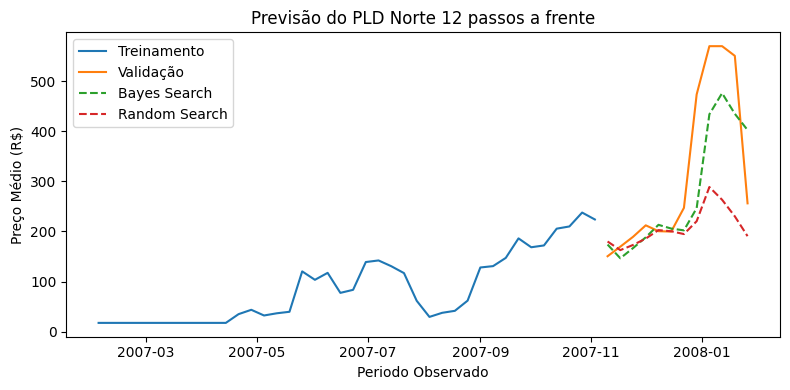

In [29]:
plot_result(predictions1=pred_bs['previsao'], legenda1='Bayes Search', predictions2=pred_rs['previsao'], legenda2='Random Search', y_true=pred_rs['validacao'], title='Previsão do PLD Norte 12 passos a frente', xlabel='Preço Médio (R$)')

### Ajuste das previsões para comparação

In [30]:
train_data_features['t'][len(train_data_features)-5:]

inicio_semana
2007-09-01    128.10
2007-09-08    130.81
2007-09-15    147.26
2007-09-22    186.16
2007-09-29    168.46
Name: t, dtype: float64

In [31]:
pred_bs['validacao']

inicio_semana
2007-11-10    [150.54]
2007-11-17    [169.65]
2007-11-24    [189.25]
2007-12-01     [212.2]
2007-12-08    [200.48]
2007-12-15    [199.76]
2007-12-22    [247.01]
2007-12-29     [473.3]
2008-01-05    [569.59]
2008-01-12    [569.59]
2008-01-19    [550.28]
2008-01-26    [256.05]
Name: validacao, dtype: object

In [32]:
test_set[:12]

,preco_medio
inicio_semana,
2007-11-10,181.30
2007-11-17,150.54
2007-11-24,169.65
2007-12-01,189.25
2007-12-08,212.20
2007-12-15,200.48
2007-12-22,199.76
2007-12-29,247.01
2008-01-05,473.30


In [33]:
# pred_bs['previsao'].values
svm_bs = []
svm_rs = []
for p in pred_bs['previsao'].values:
    svm_bs.append(round(p[0],2))

for p in pred_rs['previsao'].values:
    svm_rs.append(round(p[0],2))

In [34]:
# arima = [190.27, 169.71, 164.08, 162.76, 206.38, 215.20, 225.42, 219.87, 271.39, 464.16, 587.26, 605.78]

arima = [190.27, 169.71, 163.83, 162.76, 206.10, 215.23, 224.31, 219.84, 271.95, 463.05, 587.35,605.08]

prev_final = test_set[:12]
prev_final['arima'] = arima
prev_final['svm_bs'] = svm_bs
prev_final['svm_rs'] = svm_rs
prev_final['validacao'] = pred_bs['validacao']
prev_final

,preco_medio,arima,svm_bs,svm_rs,validacao
inicio_semana,,,,,
2007-11-10,181.30,190.27,173.85,179.94,[150.54]
2007-11-17,150.54,169.71,146.50,162.76,[169.65]
2007-11-24,169.65,163.83,166.79,173.03,[189.25]
2007-12-01,189.25,162.76,188.26,185.79,[212.2]
2007-12-08,212.20,206.10,213.20,202.68,[200.48]
2007-12-15,200.48,215.23,205.75,200.38,[199.76]
2007-12-22,199.76,224.31,202.17,194.77,[247.01]
2007-12-29,247.01,219.84,246.42,220.37,[473.3]
2008-01-05,473.30,271.95,433.68,288.61,[569.59]


In [35]:
print('ARIMA: ',np.sqrt(mean_squared_error(prev_final['validacao'], prev_final['arima'])))

print("\nRMSE")
print('SVM BS: ',np.sqrt(mean_squared_error(prev_final['validacao'], prev_final['svm_bs'])))
print('SVM RS: ',np.sqrt(mean_squared_error(prev_final['validacao'], prev_final['svm_rs'])))

print("\nMSE")
print('SVM BS: ',mean_squared_error(prev_final['validacao'], prev_final['svm_bs']))
print('SVM RS: ',mean_squared_error(prev_final['validacao'], prev_final['svm_rs']))


ARIMA:  156.21395594931118

RMSE
SVM BS:  99.10126243730029
SVM RS:  170.35073593422874

MSE
SVM BS:  9821.060216666667
SVM RS:  29019.373233333332


In [36]:
print('ARIMA: ',np.sqrt(mean_squared_error(prev_final['preco_medio'], prev_final['arima'])))

print("\nRMSE")
print('SVM BS: ',np.sqrt(mean_squared_error(prev_final['preco_medio'], prev_final['svm_bs'])))
print('SVM RS: ',np.sqrt(mean_squared_error(prev_final['preco_medio'], prev_final['svm_rs'])))

print("\nMSE")
print('SVM BS: ',mean_squared_error(prev_final['preco_medio'], prev_final['svm_bs']))
print('SVM RS: ',mean_squared_error(prev_final['preco_medio'], prev_final['svm_rs']))


ARIMA:  69.51635173348308

RMSE
SVM BS:  64.9035187156033
SVM RS:  176.45937934361362

MSE
SVM BS:  4212.466741666668
SVM RS:  31137.912558333333


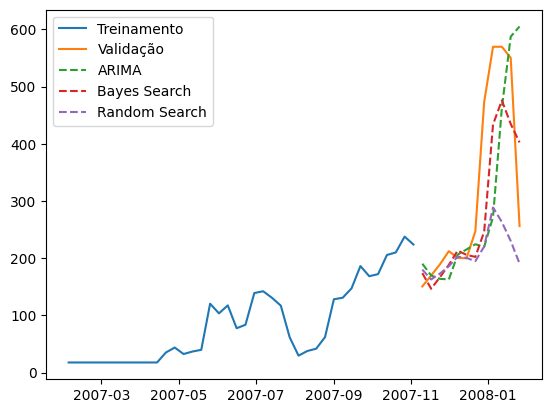

In [37]:
plt.plot(train_set[len(train_set)-40:], label='Treinamento')
# plt.plot(prev_final['preco_medio'], label='Validação')
plt.plot(prev_final['validacao'], label='Validação')
plt.plot(prev_final['arima'], '--', label='ARIMA')
plt.plot(prev_final['svm_bs'], '--', label='Bayes Search')
plt.plot(prev_final['svm_rs'], '--', label='Random Search')
plt.legend()

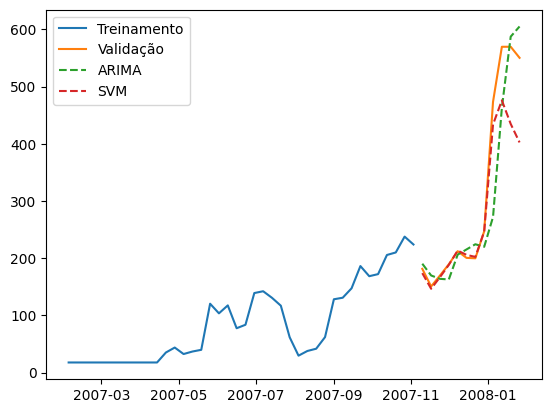

In [38]:
plt.plot(train_set[len(train_set)-40:], label='Treinamento')
plt.plot(prev_final['preco_medio'], label='Validação')
# plt.plot(prev_final['validacao'], label='Validação')
plt.plot(prev_final['arima'], '--', label='ARIMA')
plt.plot(prev_final['svm_bs'], '--', label='SVM')
plt.legend()